In [2]:
# Imports for basic data processing and visualization
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# For advanced NLP
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW  # Import AdamW from torch.optim instead of transformers
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Using device: cuda


In [7]:
!pip install -q kaggle


In [8]:
!kaggle datasets download -d andrewmvd/cyberbullying-classification


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/2.82M [00:00<?, ?B/s]
100% 2.82M/2.82M [00:00<00:00, 837MB/s]


In [9]:
!unzip cyberbullying-classification.zip


Archive:  cyberbullying-classification.zip
  inflating: cyberbullying_tweets.csv  


Dataset shape: (47692, 2)
                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying

Class distribution:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


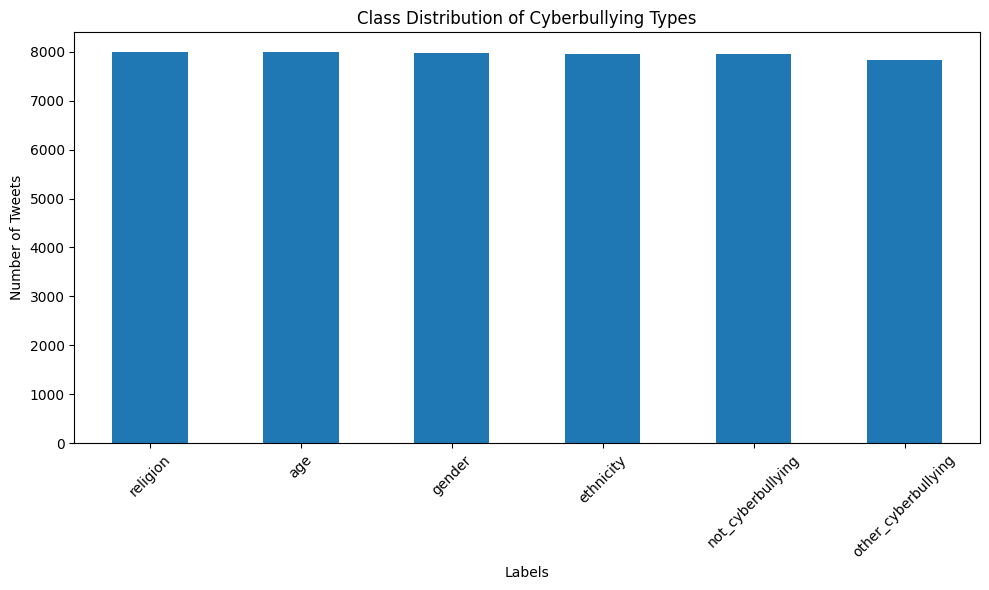

In [10]:
# Load dataset - using the specific path for the Kaggle environment
df = pd.read_csv('cyberbullying_tweets.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

# Check class distribution
print("\nClass distribution:")
class_counts = df['cyberbullying_type'].value_counts()
print(class_counts)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [13]:
# Check for missing values
print("\nChecking for missing values:")
print(df.isna().sum())

# Check for duplicates
print("\nNumber of duplicate tweets:", df.shape[0] - df['tweet_text'].nunique())

# Define preprocessing function with improved cleaning
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    """
    Comprehensive text preprocessing function
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove non-alphanumeric characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize or stem
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Apply preprocessing to tweets
print("Preprocessing tweets...")
tqdm.pandas()
df['processed_text'] = df['tweet_text'].progress_apply(preprocess_text)

# Display sample of original and processed tweets
sample_comparison = pd.DataFrame({
    'Original': df['tweet_text'].head(5),
    'Processed': df['processed_text'].head(5)
})
print("\nSample of original vs processed tweets:")
print(sample_comparison)


Checking for missing values:
tweet_text            0
cyberbullying_type    0
dtype: int64

Number of duplicate tweets: 1675
Preprocessing tweets...


  0%|          | 0/47692 [00:00<?, ?it/s]


Sample of original vs processed tweets:
                                            Original  \
0  In other words #katandandre, your food was cra...   
1  Why is #aussietv so white? #MKR #theblock #ImA...   
2  @XochitlSuckkks a classy whore? Or more red ve...   
3  @Jason_Gio meh. :P  thanks for the heads up, b...   
4  @RudhoeEnglish This is an ISIS account pretend...   

                                           Processed  
0             word katandandre food crapilicious mkr  
1  aussietv white mkr theblock imacelebrityau tod...  
2                    classy whore red velvet cupcake  
3  meh p thanks head concerned another angry dude...  
4  isi account pretending kurdish account like is...  


Analyzing word frequencies...


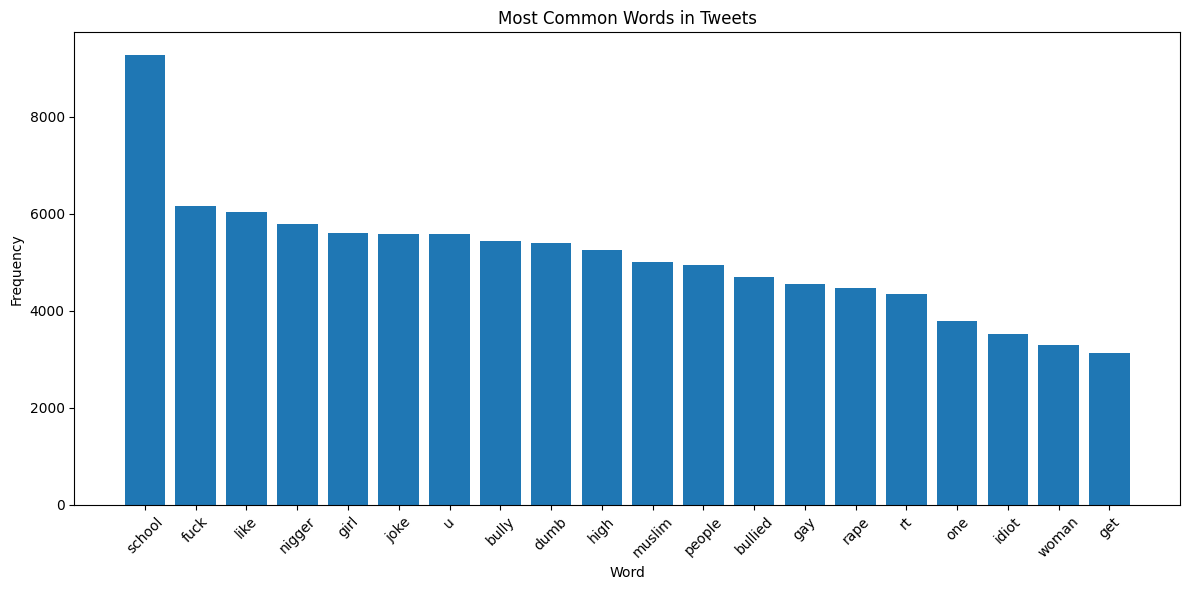

Generating word cloud...


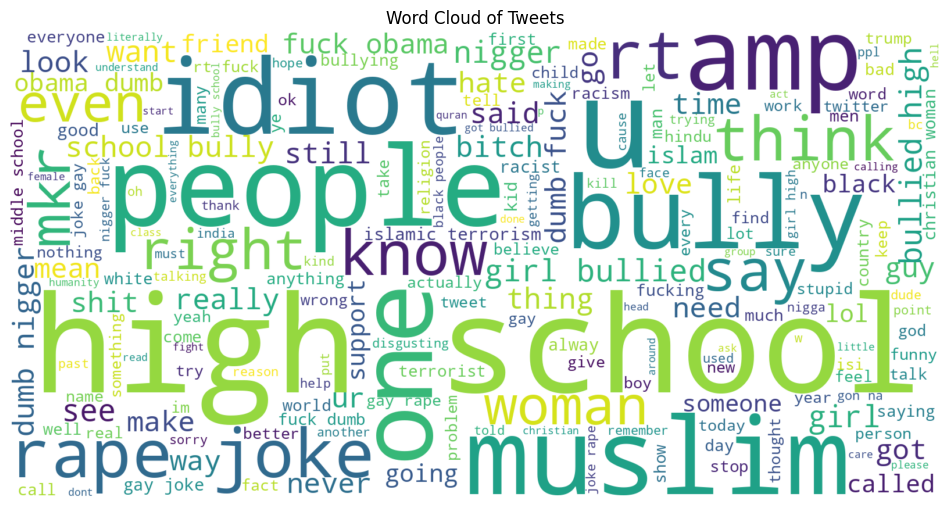

Generating word clouds by cyberbullying type...


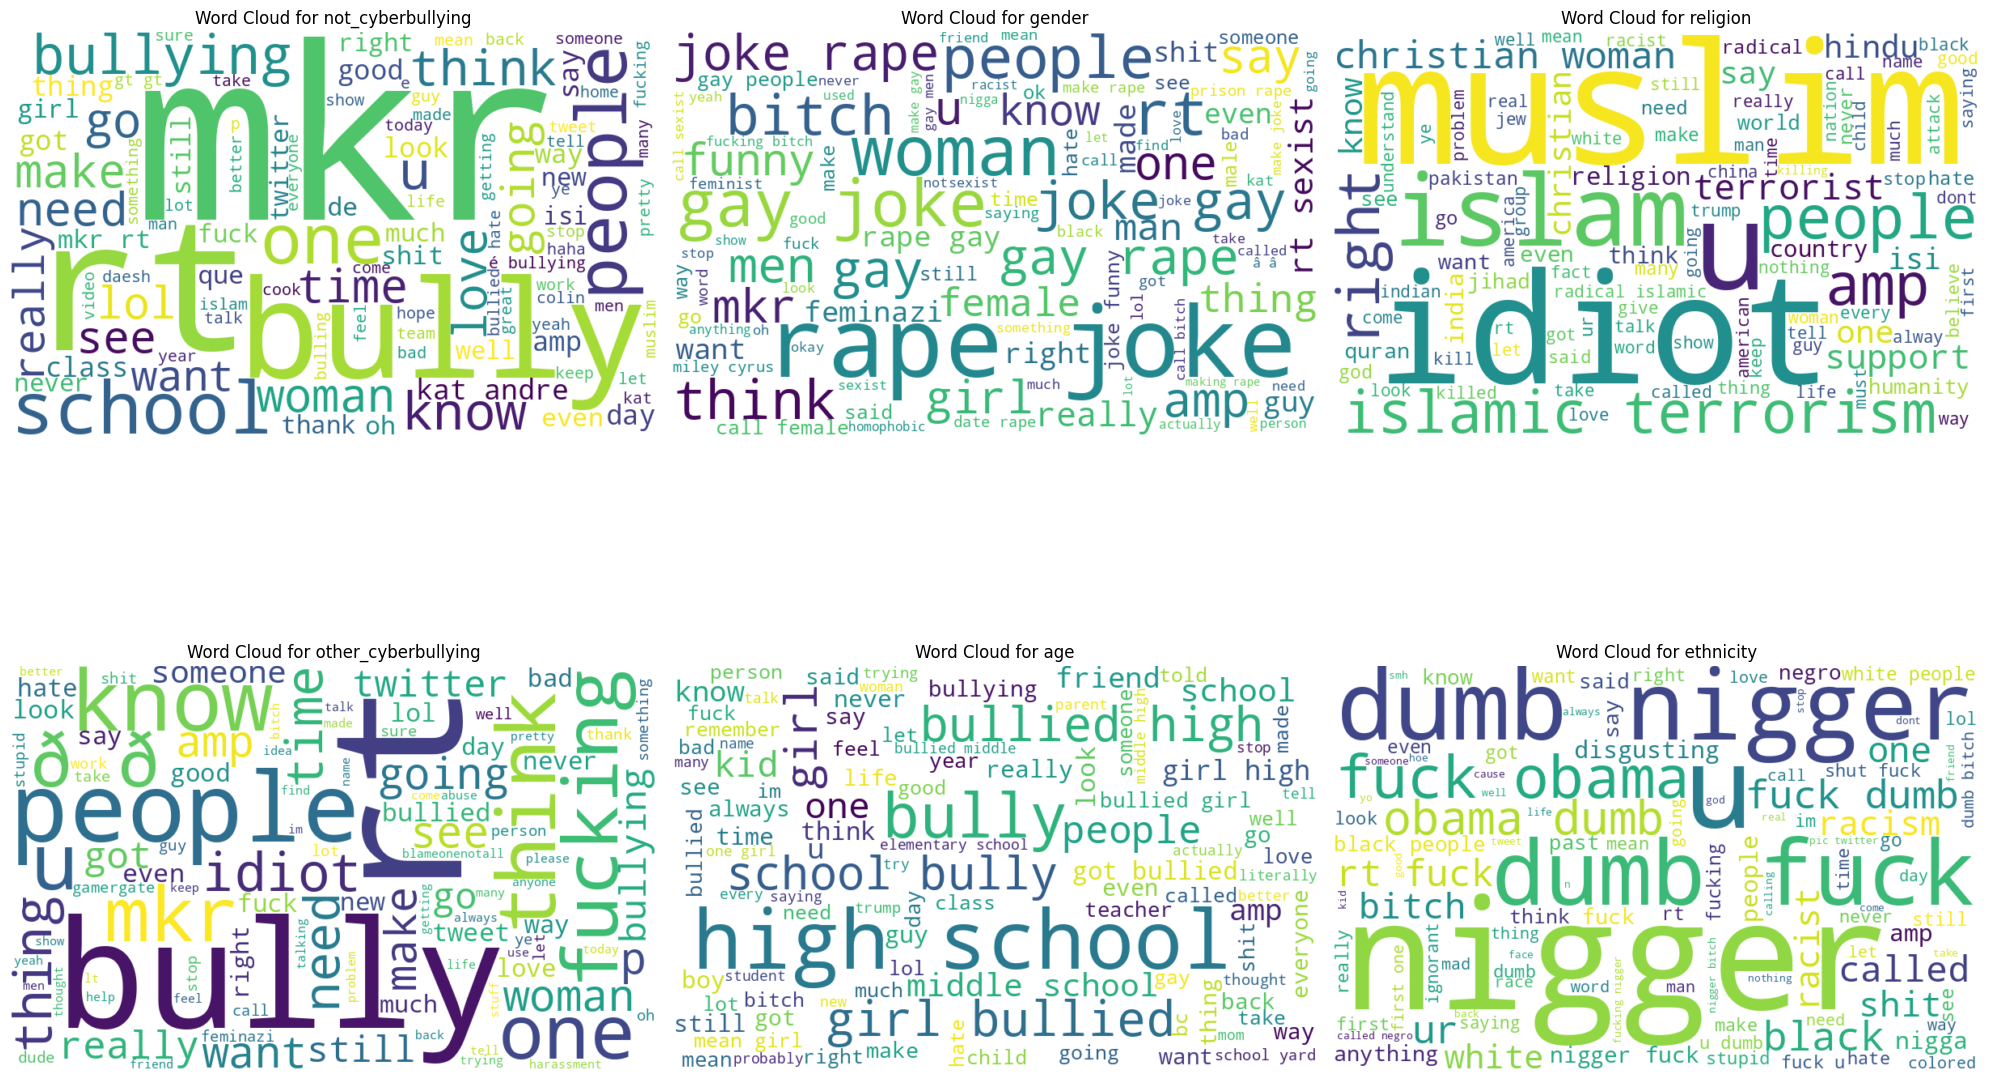

Analyzing tweet lengths...


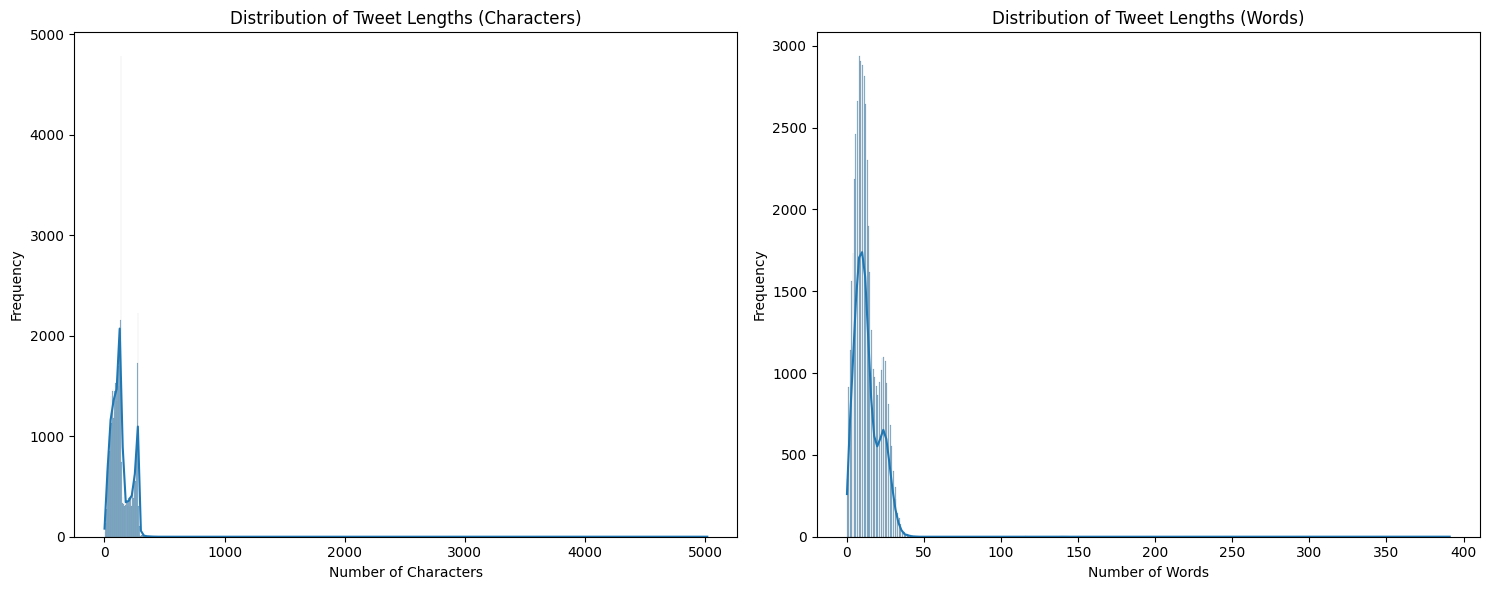

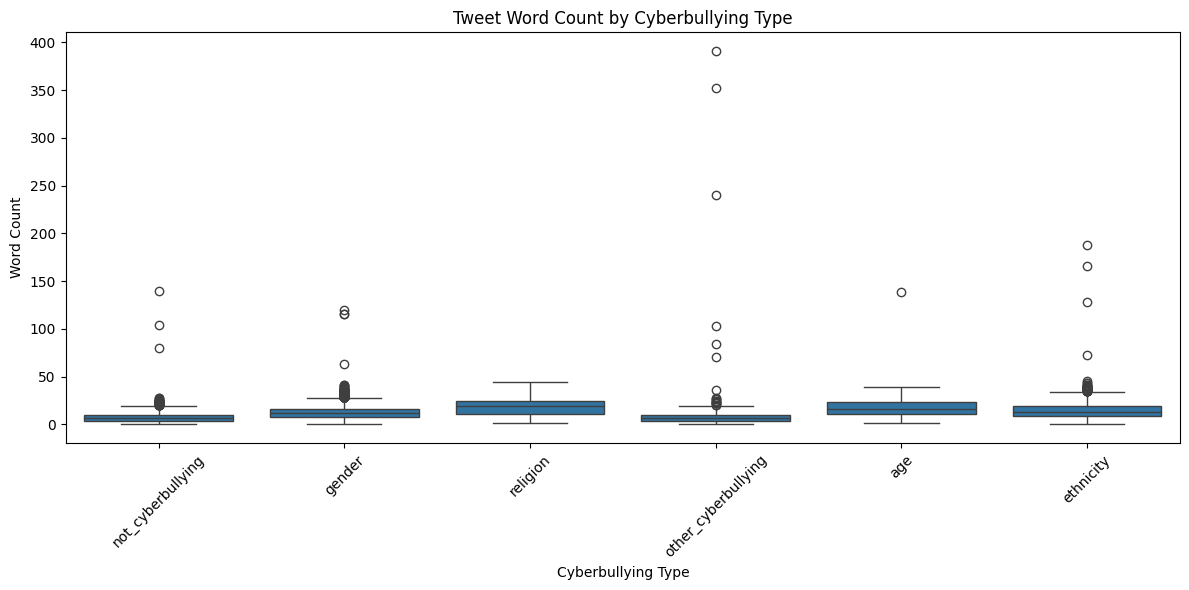

Performing sentiment analysis...


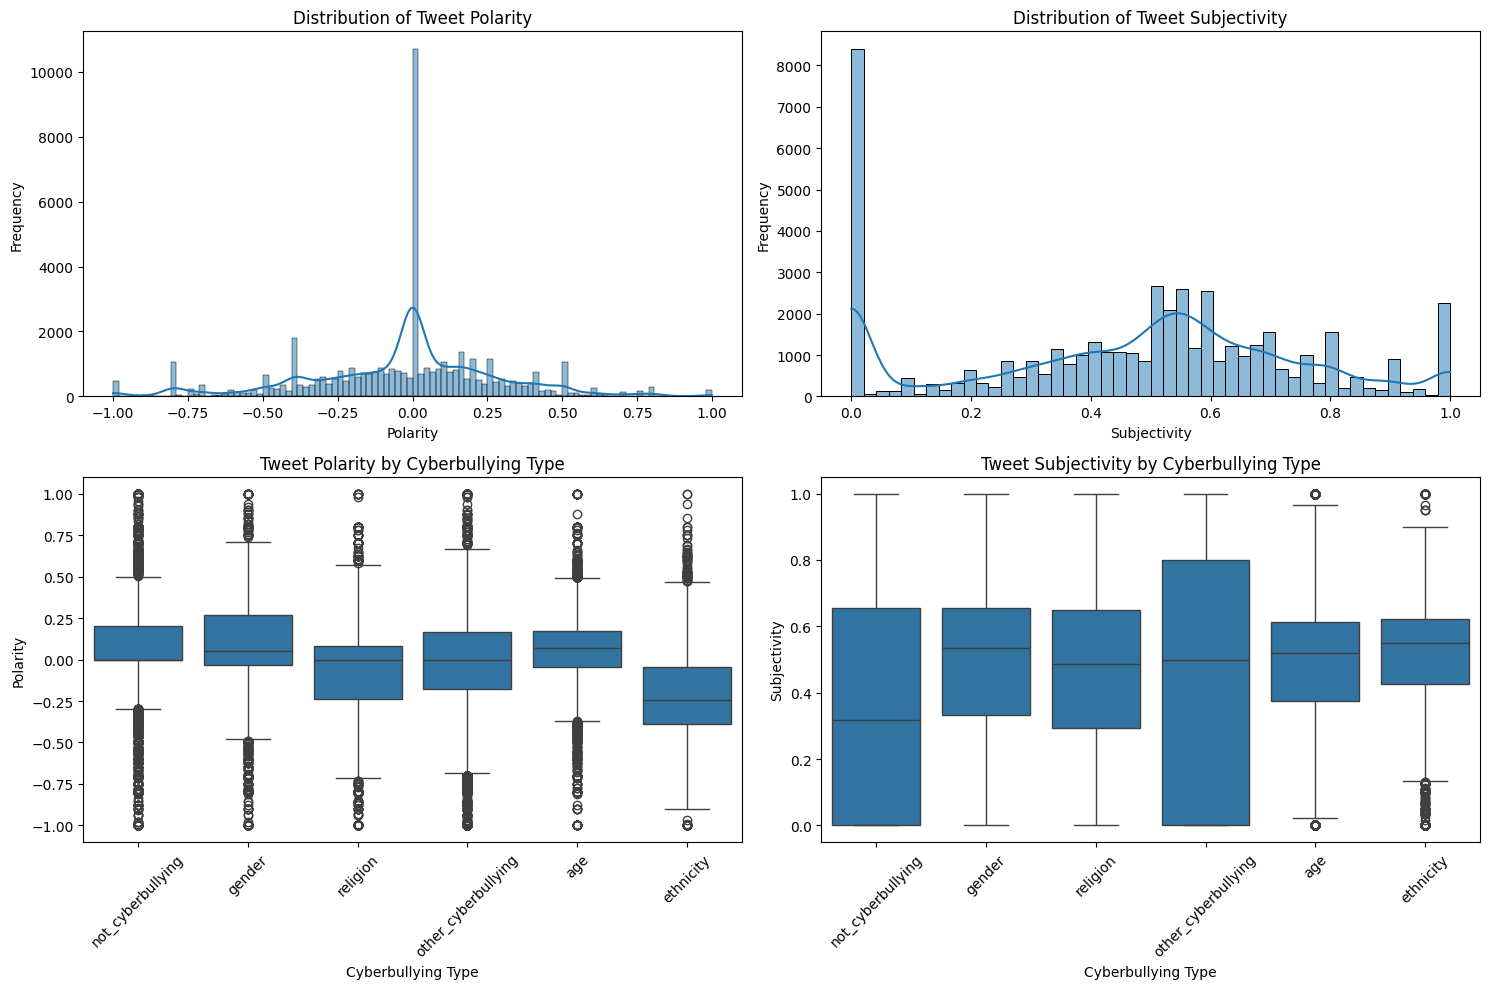

In [14]:
# 1. Word Frequency Analysis
print("Analyzing word frequencies...")
all_words = ' '.join(df['processed_text']).split()
word_counts = Counter(all_words)
top_words = word_counts.most_common(20)

# Plot top words
plt.figure(figsize=(12, 6))
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Common Words in Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Word Cloud Visualization
print("Generating word cloud...")
text = ' '.join(df['processed_text'])
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(max_words=200, width=1600, height=800, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud of Tweets')
plt.show()

# 3. Word Cloud by Class
print("Generating word clouds by cyberbullying type...")
plt.figure(figsize=(20, 15))
for i, label in enumerate(df['cyberbullying_type'].unique()):
    plt.subplot(2, 3, i+1)
    text = ' '.join(df[df['cyberbullying_type'] == label]['processed_text'])
    wordcloud = WordCloud(max_words=100, width=800, height=500, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {label}')
plt.tight_layout()
plt.show()

# 4. Tweet Length Analysis
print("Analyzing tweet lengths...")
df['tweet_length'] = df['tweet_text'].apply(len)
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['tweet_length'], kde=True)
plt.title('Distribution of Tweet Lengths (Characters)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Tweet Lengths (Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 5. Tweet Length by Class
plt.figure(figsize=(12, 6))
sns.boxplot(x='cyberbullying_type', y='word_count', data=df)
plt.title('Tweet Word Count by Cyberbullying Type')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Sentiment Analysis
print("Performing sentiment analysis...")
df['polarity'] = df['tweet_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['tweet_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['polarity'], kde=True)
plt.title('Distribution of Tweet Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(df['subjectivity'], kde=True)
plt.title('Distribution of Tweet Subjectivity')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.boxplot(x='cyberbullying_type', y='polarity', data=df)
plt.title('Tweet Polarity by Cyberbullying Type')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Polarity')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
sns.boxplot(x='cyberbullying_type', y='subjectivity', data=df)
plt.title('Tweet Subjectivity by Cyberbullying Type')
plt.xlabel('Cyberbullying Type')
plt.ylabel('Subjectivity')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Training set size: 38153
Test set size: 9539

Training traditional ML models with TF-IDF features...

Logistic Regression with TF-IDF Results:
Accuracy: 0.8233
                     precision    recall  f1-score   support

                age       0.95      0.98      0.96      1598
          ethnicity       0.97      0.97      0.97      1592
             gender       0.91      0.83      0.87      1595
  not_cyberbullying       0.59      0.52      0.55      1589
other_cyberbullying       0.58      0.70      0.63      1565
           religion       0.96      0.94      0.95      1600

           accuracy                           0.82      9539
          macro avg       0.83      0.82      0.82      9539
       weighted avg       0.83      0.82      0.82      9539



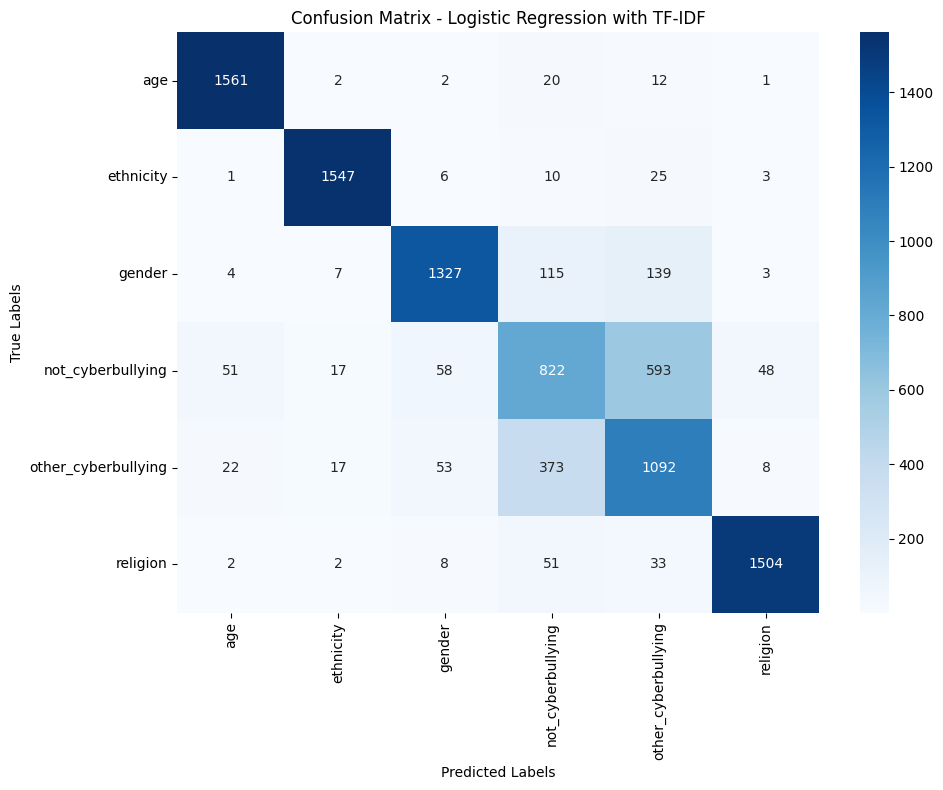


Training multiple models for comparison...
Training Logistic Regression...
Logistic Regression Accuracy: 0.8233
Training Random Forest...
Random Forest Accuracy: 0.8204
Training SVM...
SVM Accuracy: 0.8348
Training Naive Bayes...
Naive Bayes Accuracy: 0.7796


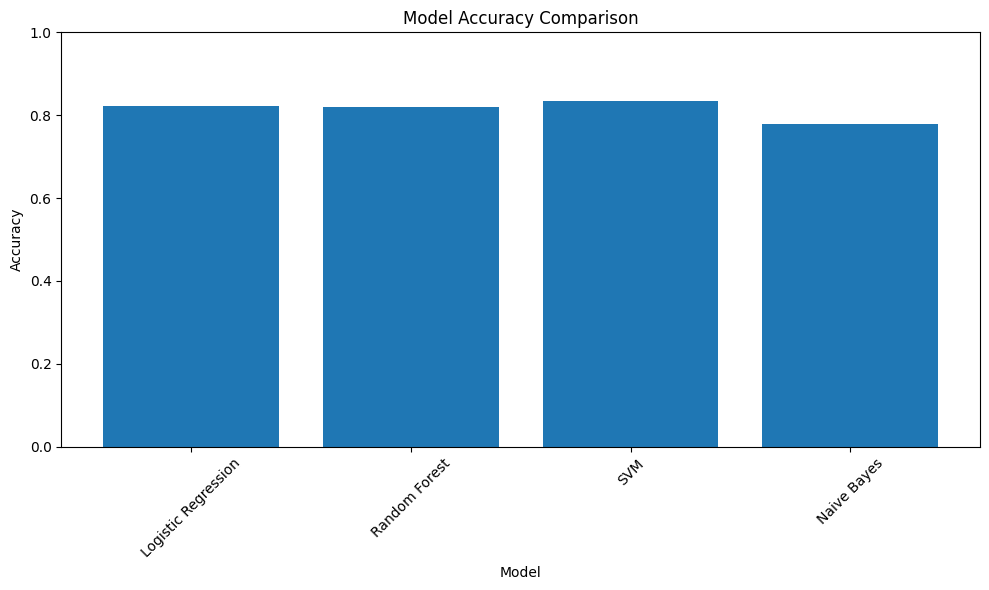


Training voting ensemble classifier...
Ensemble Accuracy: 0.8294
                     precision    recall  f1-score   support

                age       0.96      0.98      0.97      1598
          ethnicity       0.98      0.98      0.98      1592
             gender       0.92      0.85      0.88      1595
  not_cyberbullying       0.59      0.50      0.54      1589
other_cyberbullying       0.58      0.70      0.63      1565
           religion       0.96      0.96      0.96      1600

           accuracy                           0.83      9539
          macro avg       0.83      0.83      0.83      9539
       weighted avg       0.83      0.83      0.83      9539



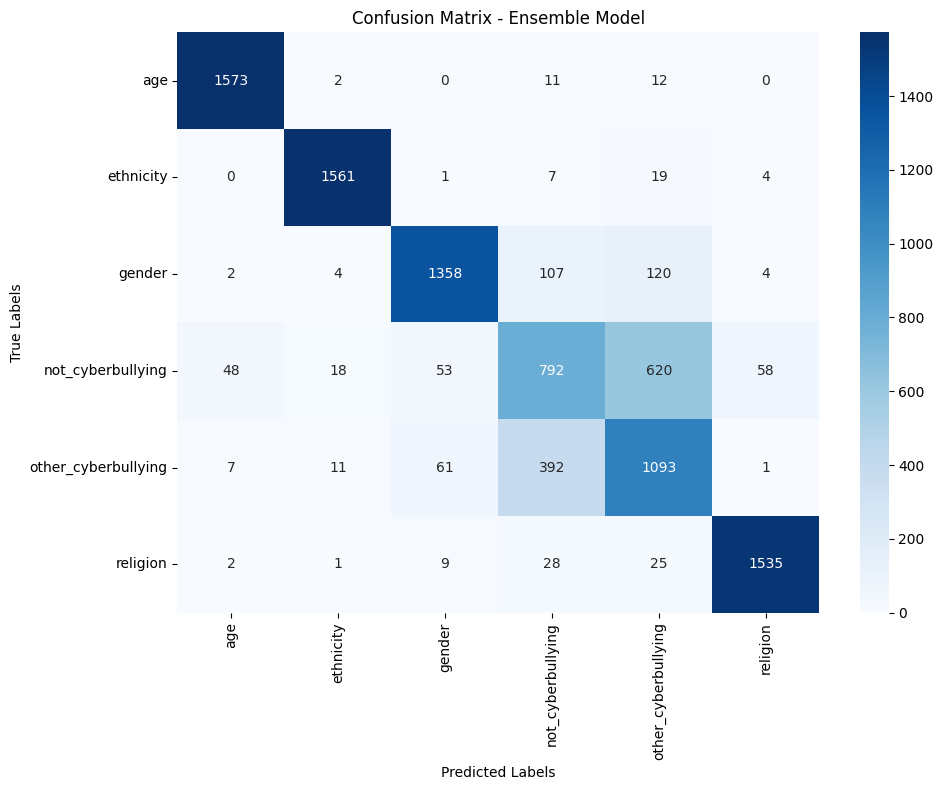

In [15]:
# Split data
X = df['processed_text']
y = df['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 1. TF-IDF Vectorization and model training
print("\nTraining traditional ML models with TF-IDF features...")

# Create a pipeline with TF-IDF and Logistic Regression
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000, C=1.0))
])

# Train the model
tfidf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_tfidf = tfidf_pipeline.predict(X_test)

# Evaluate
print("\nLogistic Regression with TF-IDF Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tfidf):.4f}")
print(classification_report(y_test, y_pred_tfidf))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Logistic Regression with TF-IDF')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

# 2. Train multiple models for comparison
print("\nTraining multiple models for comparison...")

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', C=1.0, random_state=42, probability=True),
    'Naive Bayes': MultinomialNB()
}

# Create TF-IDF features
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Plot model comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Voting Ensemble
print("\nTraining voting ensemble classifier...")
ensemble = VotingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('svm', models['SVM']),
        ('nb', models['Naive Bayes'])
    ],
    voting='soft'
)

ensemble.fit(X_train_tfidf, y_train)
y_pred_ensemble = ensemble.predict(X_test_tfidf)
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(classification_report(y_test, y_pred_ensemble))

# Plot confusion matrix for ensemble
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

Comparing all models...


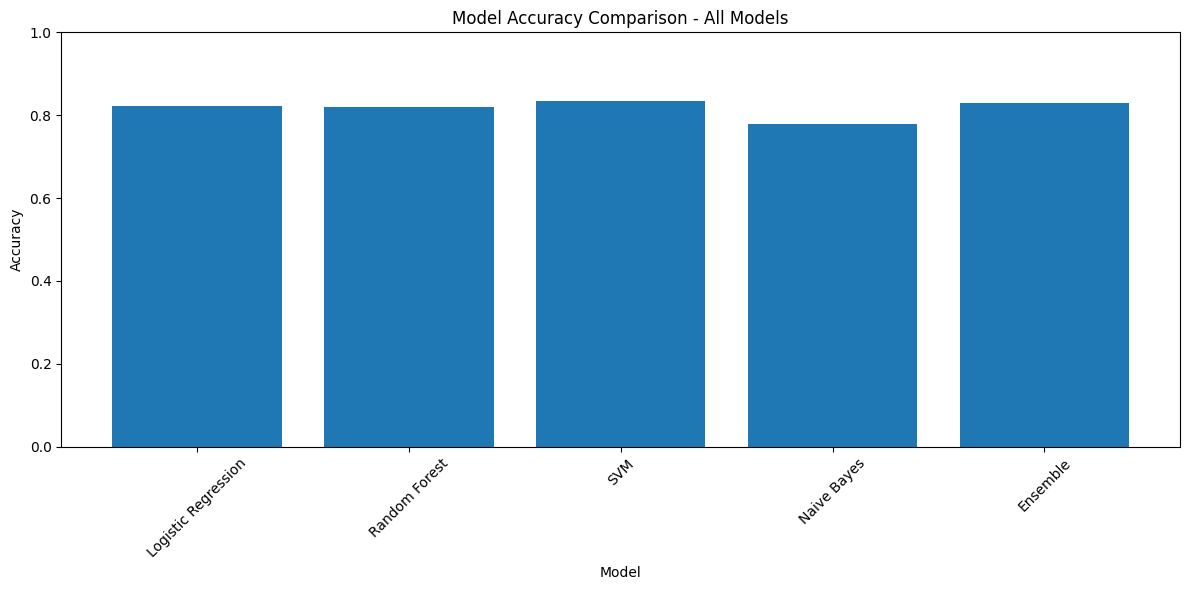

Model Performance Summary:
                 Model  Accuracy
2                  SVM  0.834784
4             Ensemble  0.829437
0  Logistic Regression  0.823252
1        Random Forest  0.820421
3          Naive Bayes  0.779641

Best performing model: SVM with accuracy 0.8348

Sample predictions from the best model:
Sample 1:
Text: like rape joke encourage rape preference endorse happened charlottesville bolster gay nazi...
True label: gender
Predicted label: gender
--------------------------------------------------
Sample 2:
Text: people trying make nigger norm make fucking cringe black shit disgusting block...
True label: ethnicity
Predicted label: ethnicity
--------------------------------------------------
Sample 3:
Text: always wanted use word sentence xinh mkr...
True label: not_cyberbullying
Predicted label: not_cyberbullying
--------------------------------------------------
Sample 4:
Text: absolutely still cracking one time wear superhero cape bart run someone sorta know...
True 

In [16]:
# Compare all models
print("Comparing all models...")

# Gather all results
all_models = {
    'Logistic Regression': results['Logistic Regression'],
    'Random Forest': results['Random Forest'],
    'SVM': results['SVM'],
    'Naive Bayes': results['Naive Bayes'],
    'Ensemble': ensemble_accuracy
}

# Plot all model accuracies
plt.figure(figsize=(12, 6))
plt.bar(all_models.keys(), all_models.values())
plt.title('Model Accuracy Comparison - All Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a summary DataFrame for model performance
summary_df = pd.DataFrame({
    'Model': list(all_models.keys()),
    'Accuracy': list(all_models.values())
}).sort_values('Accuracy', ascending=False)

print("Model Performance Summary:")
print(summary_df)

# Determine the best model
best_model = summary_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model} with accuracy {summary_df.iloc[0]['Accuracy']:.4f}")

# Sample prediction with the best model
print("\nSample predictions from the best model:")

# Get 5 random samples from test set
np.random.seed(42)
sample_indices = np.random.choice(range(len(X_test)), 5, replace=False)
samples = X_test.iloc[sample_indices].values
true_labels = y_test.iloc[sample_indices].values

# Make predictions
if best_model == 'Ensemble':
    sample_tfidf = tfidf.transform(samples)
    pred_labels = ensemble.predict(sample_tfidf)
else:
    sample_tfidf = tfidf.transform(samples)
    pred_labels = models[best_model].predict(sample_tfidf)

# Display results
for i, (sample, true, pred) in enumerate(zip(samples, true_labels, pred_labels)):
    print(f"Sample {i+1}:")
    print(f"Text: {sample[:100]}...")
    print(f"True label: {true}")
    print(f"Predicted label: {pred}")
    print("-" * 50)

print("\nCyberbullying Detection Project Completed!")

Analyzing feature importance...

Top 10 features for age:
school: 17.7213
high: 8.8750
school bully: 7.3692
girl: 7.1513
bully: 7.0877
bullied: 6.7845
bully school: 4.6724
high school: 4.5649
kid: 4.1318
teacher: 3.2277

Top 10 features for ethnicity:
nigger: 15.2266
dumb: 11.4408
past: 8.7464
black: 8.2345
negro: 8.0643
racism: 7.4615
colored: 7.4011
ur: 7.3492
first: 7.1781
white: 6.1492

Top 10 features for gender:
rape: 10.8369
gay: 9.4316
joke: 7.6470
sexist: 7.6336
female: 7.6025
feminazi: 6.2222
bitch: 5.8302
notsexist: 5.6975
rape joke: 4.7408
mkr: 4.6004

Top 10 features for not_cyberbullying:
mkr: 4.9513
bullying: 3.3152
class: 2.6970
daesh: 2.4694
mosul: 2.2558
que: 2.0322
kat andre: 2.0180
college: 1.9098
school: 1.8876
yesallwomen: 1.8580

Top 10 features for other_cyberbullying:
idiot: 4.1220
blameonenotall: 3.5882
bully: 3.4590
bullied: 2.6318
fucking: 2.4926
harassment: 2.1884
feminazi: 1.9738
gg: 1.6981
called feminazi: 1.6341
rt: 1.5870

Top 10 features for religion:


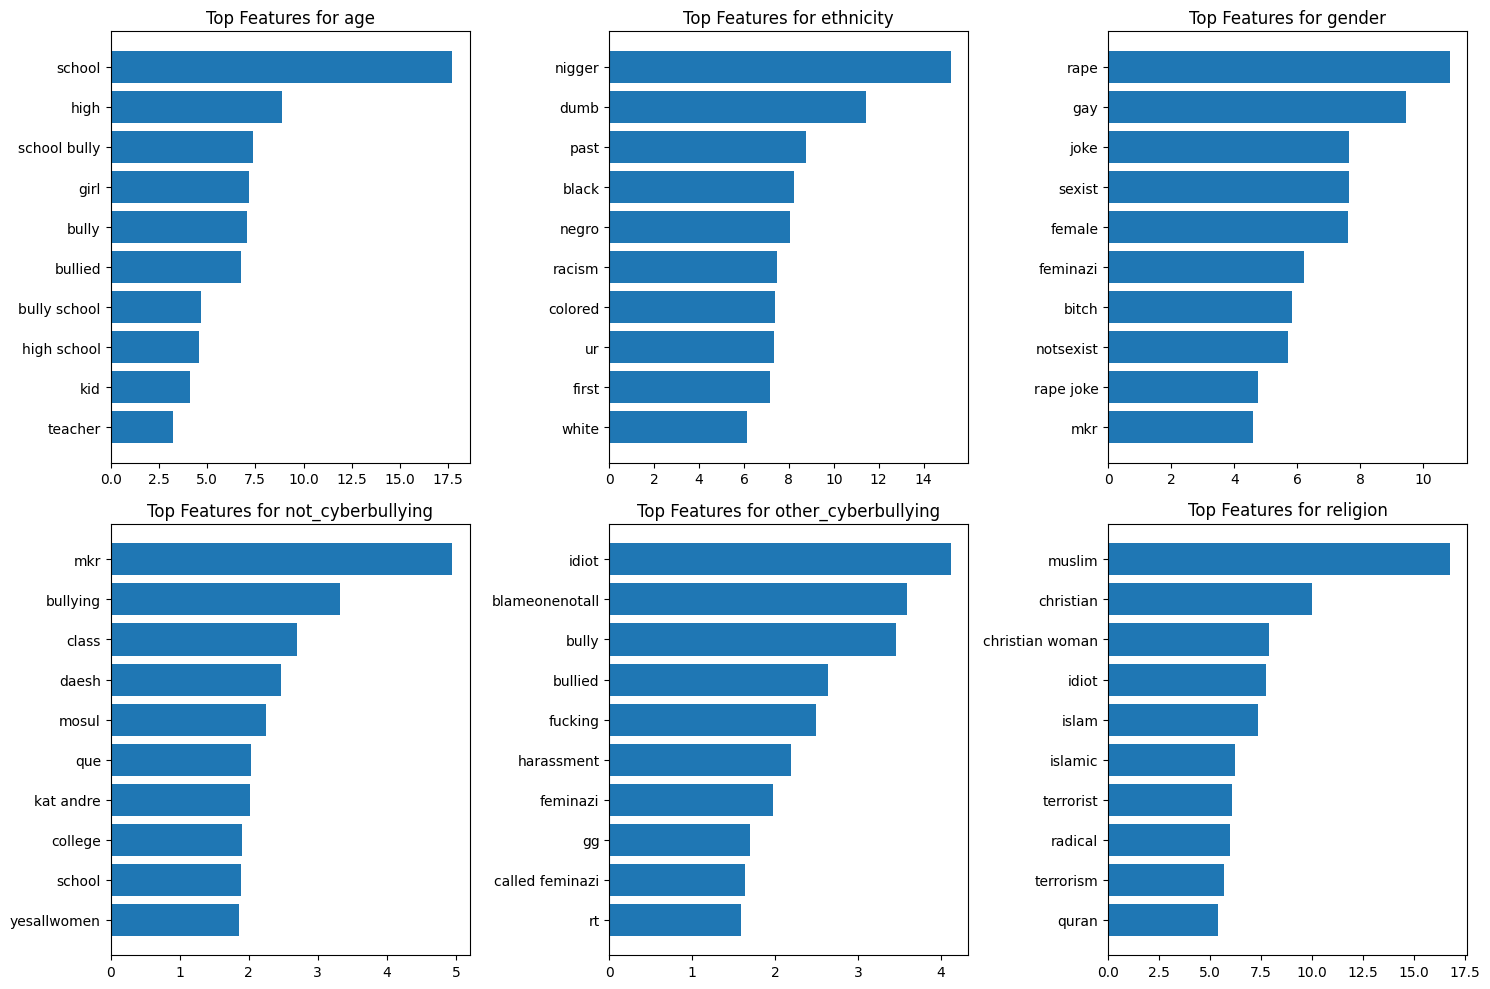

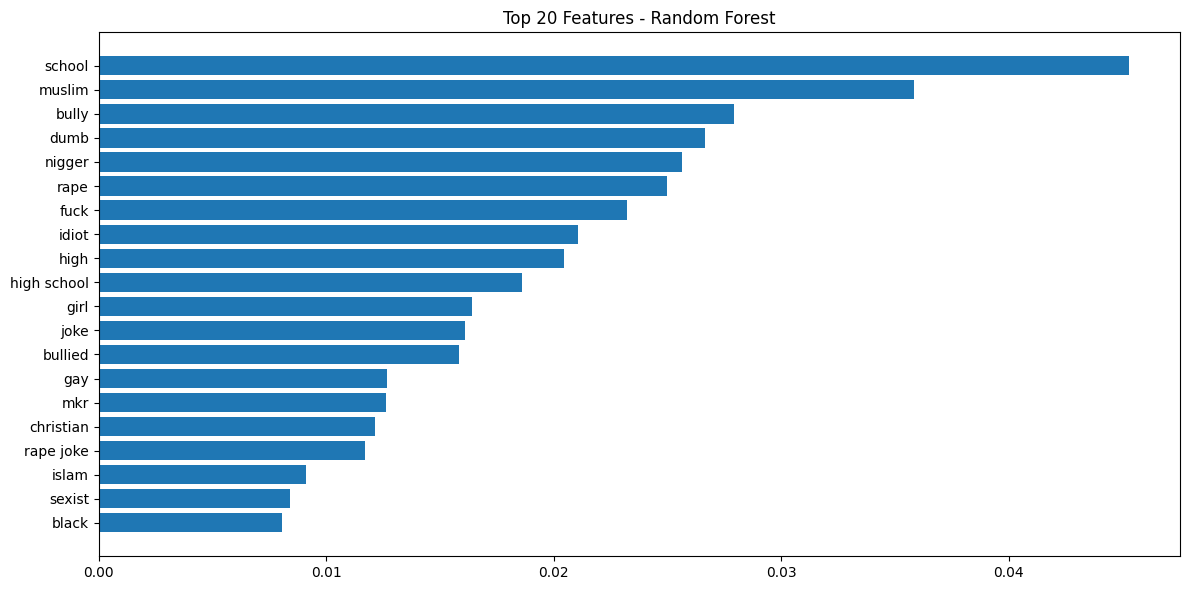

In [17]:
# Feature Importance Analysis
print("Analyzing feature importance...")

# For Logistic Regression
if 'Logistic Regression' in models:
    lr_model = models['Logistic Regression']
    feature_names = tfidf.get_feature_names_out()

    # Get coefficients for each class
    coefficients = lr_model.coef_

    # Analyze top features for each class
    for i, cyberbullying_type in enumerate(lr_model.classes_):
        print(f"\nTop 10 features for {cyberbullying_type}:")

        # Get coefficients for this class
        class_coef = coefficients[i]

        # Get indices of top features
        top_indices = np.argsort(class_coef)[-10:]

        # Print top features and their coefficients
        for idx in reversed(top_indices):
            print(f"{feature_names[idx]}: {class_coef[idx]:.4f}")

    # Visualize top features for each class
    plt.figure(figsize=(15, 10))
    for i, cyberbullying_type in enumerate(lr_model.classes_):
        plt.subplot(2, 3, i+1)

        # Get coefficients for this class
        class_coef = coefficients[i]

        # Get indices of top features
        top_indices = np.argsort(class_coef)[-10:]

        # Plot top features
        plt.barh(range(10), class_coef[top_indices], align='center')
        plt.yticks(range(10), [feature_names[idx] for idx in top_indices])
        plt.title(f'Top Features for {cyberbullying_type}')
        plt.tight_layout()

    plt.tight_layout()
    plt.show()

# For Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_names = tfidf.get_feature_names_out()

    # Get feature importances
    importances = rf_model.feature_importances_

    # Get indices of top features
    top_indices = np.argsort(importances)[-20:]

    # Plot top features
    plt.figure(figsize=(12, 6))
    plt.barh(range(20), importances[top_indices], align='center')
    plt.yticks(range(20), [feature_names[idx] for idx in top_indices])
    plt.title('Top 20 Features - Random Forest')
    plt.tight_layout()
    plt.show()

In [19]:
# Save the best model for future use
import joblib

print("Saving the best model...")

# Save the best model
if best_model == 'Ensemble':
    joblib.dump(ensemble, 'ensemble_model.pkl')
    model_path = 'ensemble_model.pkl'
else:
    joblib.dump(models[best_model], f'{best_model.lower().replace(" ", "_")}_model.pkl')
    model_path = f'{best_model.lower().replace(" ", "_")}_model.pkl'

# Save vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print(f"Model saved to {model_path}")
print("TF-IDF vectorizer saved to tfidf_vectorizer.pkl")

# Create a function for making predictions on new data
def predict_cyberbullying(text):
    """
    Predict cyberbullying type for new text

    Parameters:
    -----------
    text : str
        The text to classify

    Returns:
    --------
    str
        Predicted cyberbullying type
    """
    # Preprocess the text
    processed_text = preprocess_text(text)

    # Load the vectorizer and model
    vectorizer = joblib.load('tfidf_vectorizer.pkl')

    if best_model == 'Ensemble':
        model = joblib.load('ensemble_model.pkl')
    else:
        model = joblib.load(f'{best_model.lower().replace(" ", "_")}_model.pkl')

    # Transform the text
    text_tfidf = vectorizer.transform([processed_text])

    # Make prediction
    prediction = model.predict(text_tfidf)[0]

    return prediction

# Demo of the prediction function
print("\nDemonstrating prediction function...")
demo_texts = [
    "i will fuck you!",
    "You're so stupid, nobody likes you.",
    "Why are all [ethnicity] people so lazy?",
    "Women shouldn't be allowed to have opinions on this topic."
]

for text in demo_texts:
    pred = predict_cyberbullying(text)
    print(f"Text: {text}")
    print(f"Predicted: {pred}")
    print("-" * 50)

Saving the best model...
Model saved to svm_model.pkl
TF-IDF vectorizer saved to tfidf_vectorizer.pkl

Demonstrating prediction function...
Text: i will fuck you!
Predicted: ethnicity
--------------------------------------------------
Text: You're so stupid, nobody likes you.
Predicted: other_cyberbullying
--------------------------------------------------
Text: Why are all [ethnicity] people so lazy?
Predicted: not_cyberbullying
--------------------------------------------------
Text: Women shouldn't be allowed to have opinions on this topic.
Predicted: other_cyberbullying
--------------------------------------------------
